# Image Classification - The Simpsons

This assignment is intended to evaluate CNN performance on "The Simpsons" characters. The baseline model with some modifications is rather simple and consists of 5 convolutional layers and 3 fully connected layers with batch normalization and LeakyReLU.

## 1. Pretreatment

### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import warnings
import pickle
import PIL
import torch
import torch.nn.functional as F
import gc

from math import ceil
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from matplotlib import colors, pyplot as plt
%matplotlib inline

from os.path import exists
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

warnings.filterwarnings(action='ignore', category=DeprecationWarning)
gc.collect()

8

### Fix random seed

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

### Set processing device

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.empty_cache()
DEVICE

device(type='cuda')

### Data loading

Uncomment necessary strings depending on the used platform.

In [4]:
### Uncomment strings below if your data on colab.
# from google.colab import drive
# drive.mount('/content/gdrive/')
# !unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [5]:
### If your data on Kaggle there's no need to load data

In [6]:
### Uncomment the string below if you're working on local machine. Note that your archive should be in your working directory.
# !unzip -q journey-springfield.zip

The whole dataset is splitted on the train dataset with labels and validation one without labels. The train part contains 20933 images in the folders named to the characters. The validation dataset contains 990 images that should be classified according to these characters.

In [7]:
# Different dataset modes
DATA_MODES = ['train', 'val', 'test']
# All images are rescaled to the size 224x224 px
RESCALE_SIZE = 224

### Image loading, transform to tensors and rescaling

In [8]:
class SimpsonsDataset(Dataset):
    """
    Transform to PyTorch tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # Transform images to PyTorch tensors and normalization
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
### Copy input data for Kaggle
# from distutils.dir_util import copy_tree
# from_dir = '../input'
# to_dir = ''
# copy_tree(from_dir, to_dir)

In [10]:
### Paths for Kaggle
# TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset')
# TEST_DIR = Path('../input/journey-springfield/testset/testset')

TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          random_state=42, stratify=train_val_labels)

In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Look at the random characters.

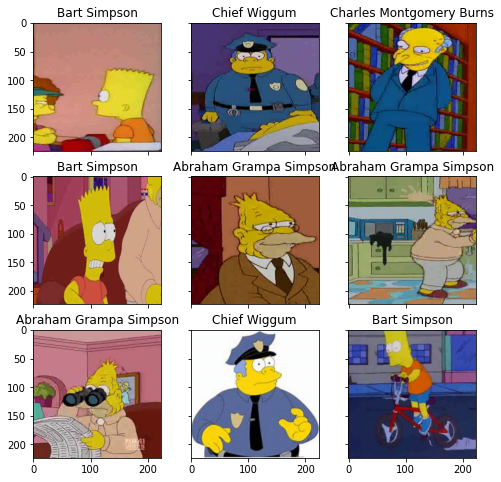

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Data analysis and simple augmentation

In [14]:
def char_distribution(labels):
    """
        A function for characters distribution visualisation
    """
    
    plt.figure(figsize=(12,10))
    ax = sns.barplot(x='count', y=labels.index, data=labels, palette="Spectral")
    ax.bar_label(ax.containers[0], padding=5)
    plt.savefig('11.jpg')
    pass

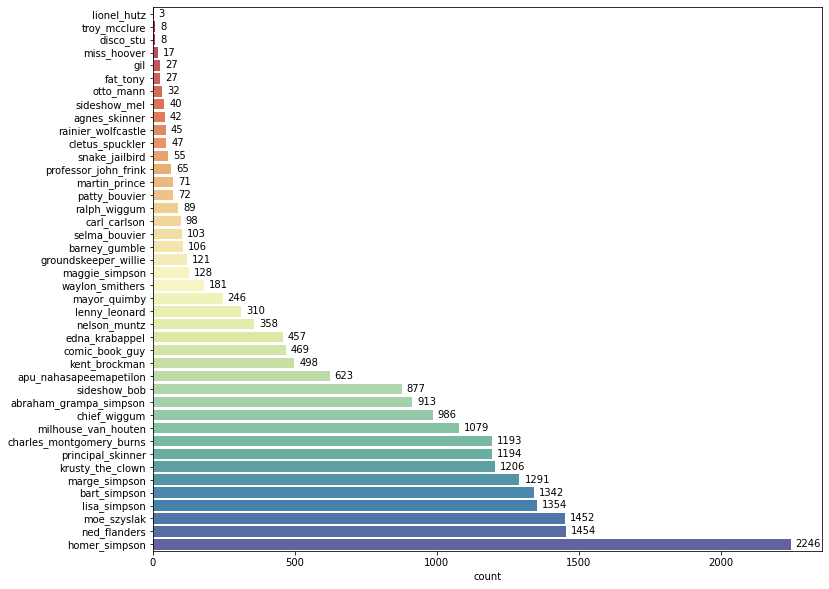

In [15]:
img_labels = pd.Series(train_val_labels).value_counts().sort_values().to_frame('count')
char_distribution(img_labels)

Obviously the disproportion is extremely high and it is very likely that the network will not account for the few in number images like "lionel_hutz" or "troy_mcclure". My solution is to complement classes that have less than 500 images to 1000 images approximately. 

In [16]:
img_labels['top_up'] = img_labels['count'].apply(lambda x: 1000 - x if x < 1000 else 0)
img_labels

,count,top_up
lionel_hutz,3,997
troy_mcclure,8,992
disco_stu,8,992
miss_hoover,17,983
gil,27,973
fat_tony,27,973
otto_mann,32,968
sideshow_mel,40,960
agnes_skinner,42,958
rainier_wolfcastle,45,955


Define some augmenting transformations that will be applied to the few in number images randomly to populate the dataset.

In [17]:
augmenters = {
    'Crop': transforms.Compose([
        transforms.Resize(size=(300, 300)),
        transforms.CenterCrop(size=RESCALE_SIZE),
        transforms.RandomCrop(RESCALE_SIZE*0.9)
        ]),
    'Rotate': transforms.RandomRotation(degrees=(-35, 35)),
    'HFlip': transforms.RandomHorizontalFlip(p=1),
    'ColorJit': transforms.ColorJitter(brightness=(0.1, 0.9), contrast=(0.1, 0.9), saturation=(0.1, 0.9)),
    'Sharpness': transforms.RandomAdjustSharpness(.9, p=0.5),
    'Invert': transforms.RandomInvert(p=0.5),
    'Perspective': transforms.RandomPerspective()
}

In [18]:
def load_sample(file):
    image = Image.open(file)
    image.load()
    return image

In [19]:
for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_sample(image_path)
    total_iters = img_labels.loc[character]['top_up']
    if total_iters < 500:
        continue
    iters = total_iters // img_labels.loc[character]['count']

    for i in range(iters):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

100%|██████████| 20933/20933 [01:10<00:00, 298.77it/s] 


As the dataset has been changed it's necessary to set train and validations files again.

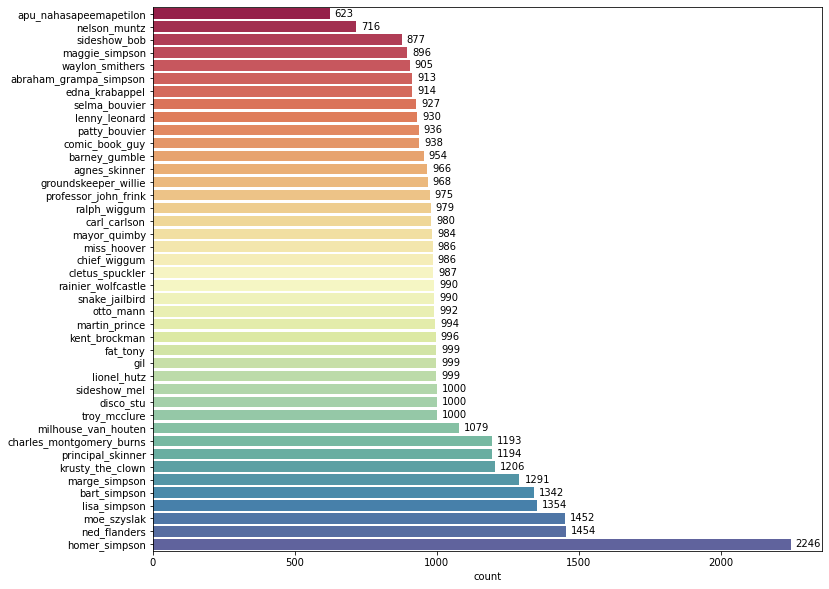

In [20]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          random_state=42, stratify=train_val_labels)
val_dataset = SimpsonsDataset(val_files, mode='val')
img_labels = pd.Series(train_val_labels).value_counts().sort_values().to_frame('count')
char_distribution(img_labels)

As one can see the distribution has become much more balanced and it is presumably can help with network training.

And let's look at the transformed images.

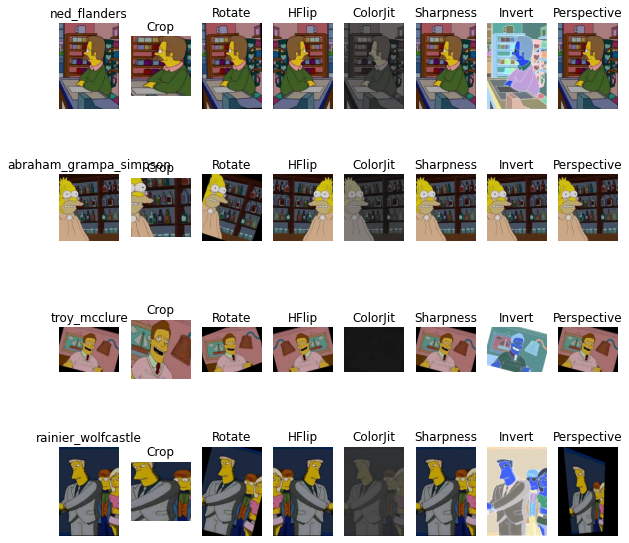

In [21]:
ex_count = 4
train_dataset = SimpsonsDataset(train_val_files, mode='train')

fig, ax = plt.subplots(nrows=ex_count, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(ex_count):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    original_image = train_dataset.load_sample(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name
    
    ax[i][0].imshow(original_image)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        augmented_image = augmenter(original_image)
        ax[i][j + 1].imshow(augmented_image)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

## 2. Network building

After a number of experiments, I made the following modifications in the baseline model: changed kernel size, added batch normalization, LeakyReLU instead of ReLU, added fully connected layers.

In [22]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(6 * 6 * 128, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU()
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(1024, n_classes)
        )  
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = F.interpolate(x, size=(6, 6), mode='bilinear')
        x = x.view(x.size(0), 6 * 6 * 128)
    
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        return x

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [25]:
def train(train_files, val_files, model, criterion, opt, scheduler, epochs, batch_size):
    # If working on colab or kaggle don't use num_workers.
    # On the local machine set this value according to your hardware
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [27]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))  
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0

## 3. Train network

In [28]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

Training will be done in two runs with 10 epochs each: the first run with learning rate 0.001 and the second one with 0.00001. Please note that every run takes about 10 minutes on the local machine. Processing duration is MUCH LONGER on colab and kaggle.

In [29]:
b_size = 64
max_epoch = 10
loss = torch.nn.CrossEntropyLoss()
history = []
for l_rate in (1e-3, 1e-5):
    optimizer = torch.optim.Adam(simple_cnn.parameters(), amsgrad=True, lr=l_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
    current_run = train(train_dataset, val_dataset, model=simple_cnn, criterion=loss, opt=optimizer, scheduler=scheduler, epochs=max_epoch, batch_size=b_size)
    history.extend(current_run)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.720739270926765


epoch:  10%|█         | 1/10 [05:17<47:37, 317.54s/it]


Epoch 001 train_loss: 1.7207     val_loss 1.2280 train_acc 0.5299 val_acc 0.6564
loss 1.0209270014943408


epoch:  20%|██        | 2/10 [06:14<21:52, 164.11s/it]


Epoch 002 train_loss: 1.0209     val_loss 0.8859 train_acc 0.7126 val_acc 0.7554
loss 0.6527846017086001


epoch:  30%|███       | 3/10 [07:03<13:02, 111.73s/it]


Epoch 003 train_loss: 0.6528     val_loss 0.6644 train_acc 0.8141 val_acc 0.8182
loss 0.48778549154257184


epoch:  40%|████      | 4/10 [07:52<08:42, 87.03s/it] 


Epoch 004 train_loss: 0.4878     val_loss 0.6223 train_acc 0.8583 val_acc 0.8346
loss 0.35328582040686857


epoch:  50%|█████     | 5/10 [08:41<06:06, 73.37s/it]


Epoch 005 train_loss: 0.3533     val_loss 0.5394 train_acc 0.8973 val_acc 0.8617
loss 0.27651481658922955


epoch:  60%|██████    | 6/10 [09:31<04:20, 65.23s/it]


Epoch 006 train_loss: 0.2765     val_loss 0.5965 train_acc 0.9196 val_acc 0.8529
loss 0.2345584085271543


epoch:  70%|███████   | 7/10 [10:20<02:59, 59.98s/it]


Epoch 007 train_loss: 0.2346     val_loss 0.5204 train_acc 0.9322 val_acc 0.8735
loss 0.18530798506315158


epoch:  80%|████████  | 8/10 [11:09<01:53, 56.52s/it]


Epoch 008 train_loss: 0.1853     val_loss 0.4730 train_acc 0.9463 val_acc 0.8844
loss 0.05835365698419678


epoch:  90%|█████████ | 9/10 [11:58<00:54, 54.23s/it]


Epoch 009 train_loss: 0.0584     val_loss 0.3311 train_acc 0.9837 val_acc 0.9271
loss 0.028601135767543844


epoch: 100%|██████████| 10/10 [12:48<00:00, 76.81s/it]



Epoch 010 train_loss: 0.0286     val_loss 0.3455 train_acc 0.9926 val_acc 0.9269


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.01883237865788626


epoch:  10%|█         | 1/10 [00:49<07:25, 49.51s/it]


Epoch 001 train_loss: 0.0188     val_loss 0.3527 train_acc 0.9954 val_acc 0.9302
loss 0.01503342344383708


epoch:  20%|██        | 2/10 [01:39<06:36, 49.58s/it]


Epoch 002 train_loss: 0.0150     val_loss 0.3621 train_acc 0.9964 val_acc 0.9310
loss 0.012386286546775286


epoch:  30%|███       | 3/10 [02:28<05:46, 49.45s/it]


Epoch 003 train_loss: 0.0124     val_loss 0.3719 train_acc 0.9974 val_acc 0.9313
loss 0.010533710330940551


epoch:  40%|████      | 4/10 [03:17<04:55, 49.32s/it]


Epoch 004 train_loss: 0.0105     val_loss 0.3816 train_acc 0.9978 val_acc 0.9320
loss 0.00890716812955794


epoch:  50%|█████     | 5/10 [04:08<04:08, 49.73s/it]


Epoch 005 train_loss: 0.0089     val_loss 0.3909 train_acc 0.9981 val_acc 0.9318
loss 0.007661527965126618


epoch:  60%|██████    | 6/10 [04:57<03:18, 49.65s/it]


Epoch 006 train_loss: 0.0077     val_loss 0.3989 train_acc 0.9984 val_acc 0.9319
loss 0.006676385456502857


epoch:  70%|███████   | 7/10 [05:47<02:28, 49.64s/it]


Epoch 007 train_loss: 0.0067     val_loss 0.4073 train_acc 0.9987 val_acc 0.9318
loss 0.005636448984285242


epoch:  80%|████████  | 8/10 [06:36<01:39, 49.59s/it]


Epoch 008 train_loss: 0.0056     val_loss 0.4153 train_acc 0.9990 val_acc 0.9314
loss 0.004831015053611267


epoch:  90%|█████████ | 9/10 [07:25<00:49, 49.48s/it]


Epoch 009 train_loss: 0.0048     val_loss 0.4156 train_acc 0.9991 val_acc 0.9318
loss 0.004617703090891284


epoch: 100%|██████████| 10/10 [08:15<00:00, 49.59s/it]


Epoch 010 train_loss: 0.0046     val_loss 0.4162 train_acc 0.9992 val_acc 0.9315


Clear GPU memory

In [30]:
torch.cuda.empty_cache()
gc.collect()

12584

Look at the training curves

In [31]:
loss, acc, val_loss, val_acc = zip(*history)

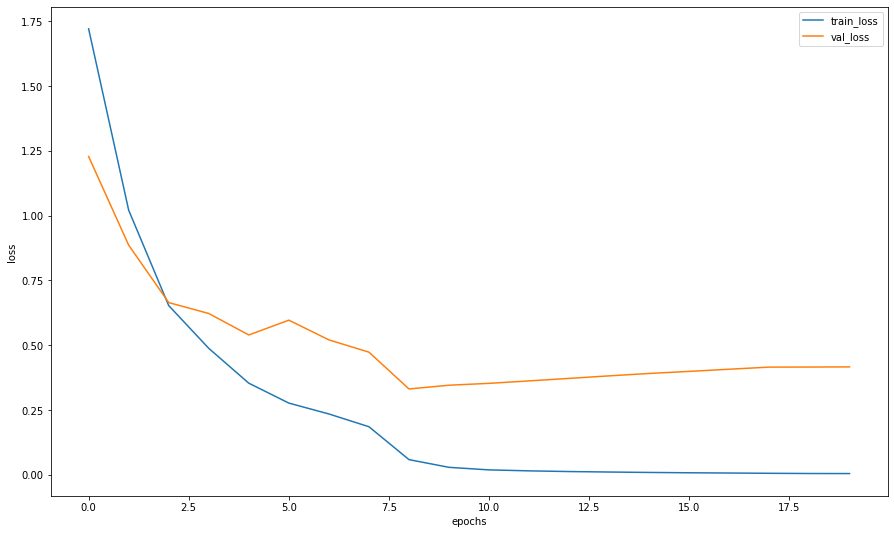

In [32]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [33]:
val_acc_fig = tuple(val_acc[i].cpu() for i in range(max_epoch*2))

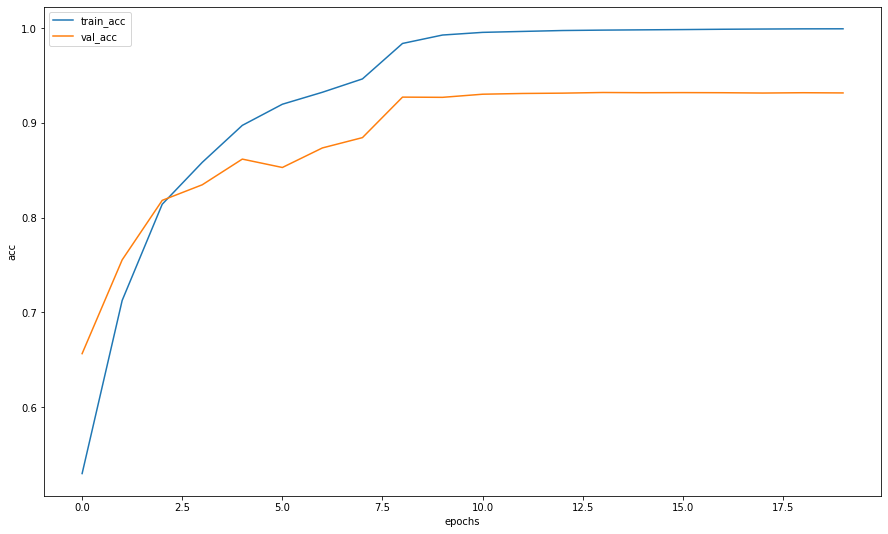

In [34]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc_fig, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

## 4. Results and submit

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

It's time to evaluate predictive capability of the network. The selected metrics for this assignment is f1_score.

In [35]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [36]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [37]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [38]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [39]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [40]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='micro')

0.9500000000000001

Visualise the results and check classified images.

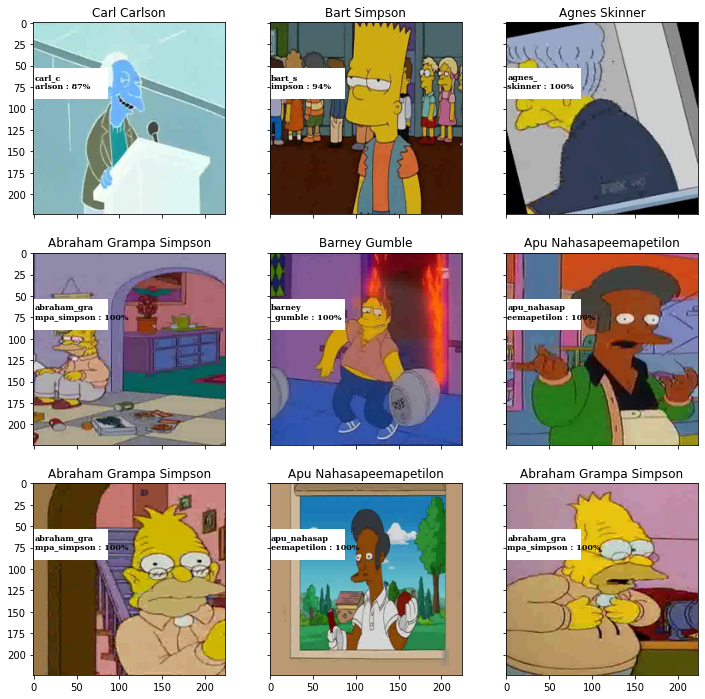

In [41]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("serif")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [42]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [43]:
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('simpsons_batch_norm_adam_2_runs_changed_kernels_loc.csv', index=False)

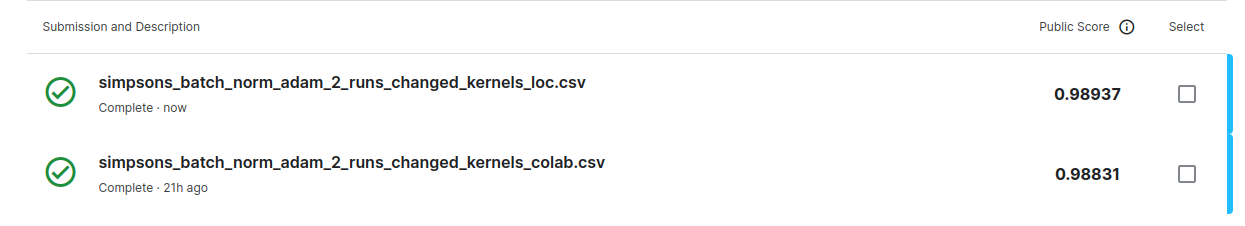